# Requirements
* 1.Walk through your model step by step, starting with EDA
    * What are your variables of interest?
    * What outliers did you remove?
    * What types of data imputation did you perform?
 
* 2.Summarize your statistical analysis, including:
    * model selection
    * implementation
    * evaluation
    * inference

# Identifying the best features for a new residential aged care facility due to future insufficiency

###  Assumptions:
* Future residential beds are based on the level of occupancy against the population of people who are 65 years old and over
* All factors related to the care of the elderly are sufficient and remains constant. An example is the staff to patient ratios. 
* The location of the residential aged care facility may not be the location where a person has lived most of their life. An example would be a person entering residential aged care facility that is located where his/ her children are currently residing. 
* The government funding provided for each residential aged care facility in 2017 does not require adjustment
* The estimated population will have a high fertility rate ie: A_65


### Variables of interest
* Australian Government Funding
* Longitude and Latitute of each residential aged care facility
* Residential - places offered in each each residential aged care facility
* Using distance as a measure to create the key location feature. As such, distances are calculated from  the key location to each residential aged care facility
    * Longitude and Latitude of Prince of Wales Hospital (Ranwick) - (151.2387, -33.9190)
    * Longitude and Latitude of Bondi Beach - (151.274292, -33.89084)
       

### Outliers
* The population data used is not granular. As such, it it assumed there is no outliners.
* However, the location of each residential aged care facility was uploaded into Tableau to view the density of its positions. From here it was discovered that 2 facilities lies in the middle of the ocean. This is considered to be an outliner. However, since it was only 2 facilities, a decision was made to ignore the outliers as it has nominal impact on the models. 


### Data Imputation
* No data imputation was required. Although the sample size was small, a prediction was possible

### EDA
* Check correlation of the distances and found that all the distances are highly correlated. This is due to the fact that the distance is calculated using the longitude and latitute of each residential aged care facility

### Models used:
* Since the target (Australian Government Funding) is continous, the following models were used: 
    •	Logistic Regression – 97%
    •	K Nearest Neighbours (KNN) – 65.61%
    •	GridSearch – 97.42%
    •	Support Vector Machine (SVM) – 97.52% 

* Main coefficient identified was places in residential aged care

### Why these modesl?
   * K Nearest Neighbours (KNN) – 65.61%
        * simple algorithm
        * stores all available cases and classifies new cases based on a similarity measure (e.g., distance functions)
        * is automatically non-linear
        * detect linear or non-linear distributed data
        * BUT sensitive to outliers – knn score of 65.61% is the lowest of all models
   
   * Support Vector Machine (SVM) – 97.52% 
   
        * uses a technique called the kernel trick to transform data and finds an optimal boundary between the possible outputs
        * SVM is good with outliers as it uses the most relevant points to find a linear separation – svm score of 97.52% is the highest of all models
        * But processing svm is slow

### Inference/ Result

* The results suggested the level of government funding is influenced by the number of places in a residential aged care rather than the distance to the hospital and the beach. This is seen by the scores above. 

### Next Steps
* Determine if location affluence and private individual cost of entering a residential aged care impacts government funding received
* Sentiments on individual residential aged care facility – difficult as there is insufficient online data

## Further EDA

#### R2  is a measure of how much variance in the target/dependent variable is explained by our predictor variables.

In [3]:
# Initialize imports
import numpy as np
import scipy.stats as stats
from scipy.stats import t
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pandas.io import sql
import sqlite3
import patsy

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [4]:
# Initialize imports
from sklearn import cluster, metrics
import matplotlib
matplotlib.style.use('ggplot') 

In [5]:
# Initialize imports
import sqlite3
sqlite_db = './openlib.db'
conn = sqlite3.connect(sqlite_db) 
c = conn.cursor()

In [6]:
# In case typing out `sql.read_sql()` is a little too much,# we'll create a function shortcut.

c = sqlite3.connect('./openlib.db')

def Q(query, db=c):
    return sql.read_sql(query, db)

In [7]:
# select records
feature=Q('SELECT * FROM feature_NSW')
feature.head()

,Servicename,PhysicalAddressSuburb,Year,Residential,AustralianGovernmentFunding,Longitude,Latitude,dist_Clovelly,dist_BondiJunction,dist_Maroubra,dist_Coogee,dist_Vincent,dist_CBD,dist_Alfred,dist_Wales,dist_StGeorge,dist_Bondi
0,St Basil's Annandale,ANNANDALE,2016-2017,83,5146461,151.172733,-33.875890,9.581138,7.306635,10.475849,9.012864,4.464116,3.631338,1.765183,7.744212,10.814297,9.515312
1,Macquarie Lodge Aged Care Plus Centre,ARNCLIFFE,2016-2017,130,8788135,151.134856,-33.939656,12.462862,11.870958,10.093471,11.358169,10.297439,10.792123,7.102859,9.846089,3.107814,13.956046
2,A H Orr Lodge,ASHFIELD,2016-2017,60,3258005,151.125841,-33.894955,13.112118,11.431866,12.443875,12.252993,8.905851,8.432963,5.270597,10.746170,8.103484,13.701145
3,Opal Cardinal Freeman,ASHFIELD,2016-2017,135,5584660,151.127894,-33.895950,12.908027,11.247006,12.224675,12.044253,8.740665,8.304075,5.096899,10.535436,7.978874,13.516029
4,Weeroona Aged Care Plus Centre,BASS HILL,2016-2017,104,7057385,151.003471,-33.899572,24.285303,22.730356,22.835483,23.343486,20.159469,19.424499,16.560951,21.801215,14.172966,24.999496


In [8]:
# calculate the cost per bed based on government funding and places
p=feature.Residential
b=feature.AustralianGovernmentFunding

feature['fundperbed']=b/p

In [9]:
# check column types
feature.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555 entries, 0 to 554
Data columns (total 18 columns):
Servicename                    555 non-null object
PhysicalAddressSuburb          555 non-null object
Year                           555 non-null object
Residential                    555 non-null int64
AustralianGovernmentFunding    555 non-null int64
Longitude                      555 non-null float64
Latitude                       555 non-null float64
dist_Clovelly                  555 non-null float64
dist_BondiJunction             555 non-null float64
dist_Maroubra                  555 non-null float64
dist_Coogee                    555 non-null float64
dist_Vincent                   555 non-null float64
dist_CBD                       555 non-null float64
dist_Alfred                    555 non-null float64
dist_Wales                     555 non-null float64
dist_StGeorge                  555 non-null float64
dist_Bondi                     555 non-null float64
fundperbed        

In [10]:
# check columns
feature.describe()

,Residential,AustralianGovernmentFunding,Longitude,Latitude,dist_Clovelly,dist_BondiJunction,dist_Maroubra,dist_Coogee,dist_Vincent,dist_CBD,dist_Alfred,dist_Wales,dist_StGeorge,dist_Bondi,fundperbed
count,555.000000,5.550000e+02,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000
mean,86.749550,5.019475e+06,151.191674,-33.633132,52.806083,51.234829,53.545221,52.534331,49.758634,49.053650,48.848893,51.807092,51.721704,52.405547,57872.382785
std,44.527609,2.819397e+06,0.444385,0.883420,97.990889,97.991069,98.824858,98.275300,98.306091,98.180648,99.024913,98.586449,100.585113,97.493680,14028.521859
min,11.000000,4.587600e+05,149.229375,-35.348045,1.227886,0.645431,0.865445,1.074084,0.518030,1.223988,1.417980,0.475197,0.421233,0.591874,3823.000000
25%,54.500000,2.891110e+06,151.010204,-33.915738,15.526749,14.043221,15.696141,15.109003,12.178929,11.526934,10.240175,13.911661,12.078691,15.715542,51136.280898
50%,76.000000,4.477122e+06,151.126322,-33.818408,26.350204,23.776747,27.513664,26.311645,21.900933,21.112537,20.168475,25.404286,23.563997,25.167590,59924.500000
75%,111.000000,6.730514e+06,151.263355,-33.698911,56.793105,56.088617,58.132900,57.163940,53.909223,52.544123,53.567347,56.302747,55.622739,57.315148,67045.112857
max,356.000000,2.180952e+07,153.570166,-28.175321,673.446659,671.651647,677.922011,674.363842,671.410625,670.148629,673.554756,674.881336,683.262727,670.836357,86986.239130


In [11]:
# check dataframes
feature.head()

,Servicename,PhysicalAddressSuburb,Year,Residential,AustralianGovernmentFunding,Longitude,Latitude,dist_Clovelly,dist_BondiJunction,dist_Maroubra,dist_Coogee,dist_Vincent,dist_CBD,dist_Alfred,dist_Wales,dist_StGeorge,dist_Bondi,fundperbed
0,St Basil's Annandale,ANNANDALE,2016-2017,83,5146461,151.172733,-33.875890,9.581138,7.306635,10.475849,9.012864,4.464116,3.631338,1.765183,7.744212,10.814297,9.515312,62005.554217
1,Macquarie Lodge Aged Care Plus Centre,ARNCLIFFE,2016-2017,130,8788135,151.134856,-33.939656,12.462862,11.870958,10.093471,11.358169,10.297439,10.792123,7.102859,9.846089,3.107814,13.956046,67601.038462
2,A H Orr Lodge,ASHFIELD,2016-2017,60,3258005,151.125841,-33.894955,13.112118,11.431866,12.443875,12.252993,8.905851,8.432963,5.270597,10.746170,8.103484,13.701145,54300.083333
3,Opal Cardinal Freeman,ASHFIELD,2016-2017,135,5584660,151.127894,-33.895950,12.908027,11.247006,12.224675,12.044253,8.740665,8.304075,5.096899,10.535436,7.978874,13.516029,41367.851852
4,Weeroona Aged Care Plus Centre,BASS HILL,2016-2017,104,7057385,151.003471,-33.899572,24.285303,22.730356,22.835483,23.343486,20.159469,19.424499,16.560951,21.801215,14.172966,24.999496,67859.471154


In [12]:
# drop columns from the dataframe
distance=feature.drop(['dist_Clovelly','dist_BondiJunction','dist_Maroubra','dist_Coogee','dist_Vincent',
                       'dist_CBD','dist_Alfred','dist_StGeorge','PhysicalAddressSuburb','Year','AustralianGovernmentFunding',
                       'Longitude','Latitude'],axis=1)

In [13]:
# index the facility name
distance.set_index('Servicename', inplace=True)

In [14]:
# check correlation
distance.corr()

,Residential,dist_Wales,dist_Bondi,fundperbed
Residential,1.000000,0.053896,0.057218,-0.001488
dist_Wales,0.053896,1.000000,0.999552,0.047779
dist_Bondi,0.057218,0.999552,1.000000,0.051006
fundperbed,-0.001488,0.047779,0.051006,1.000000


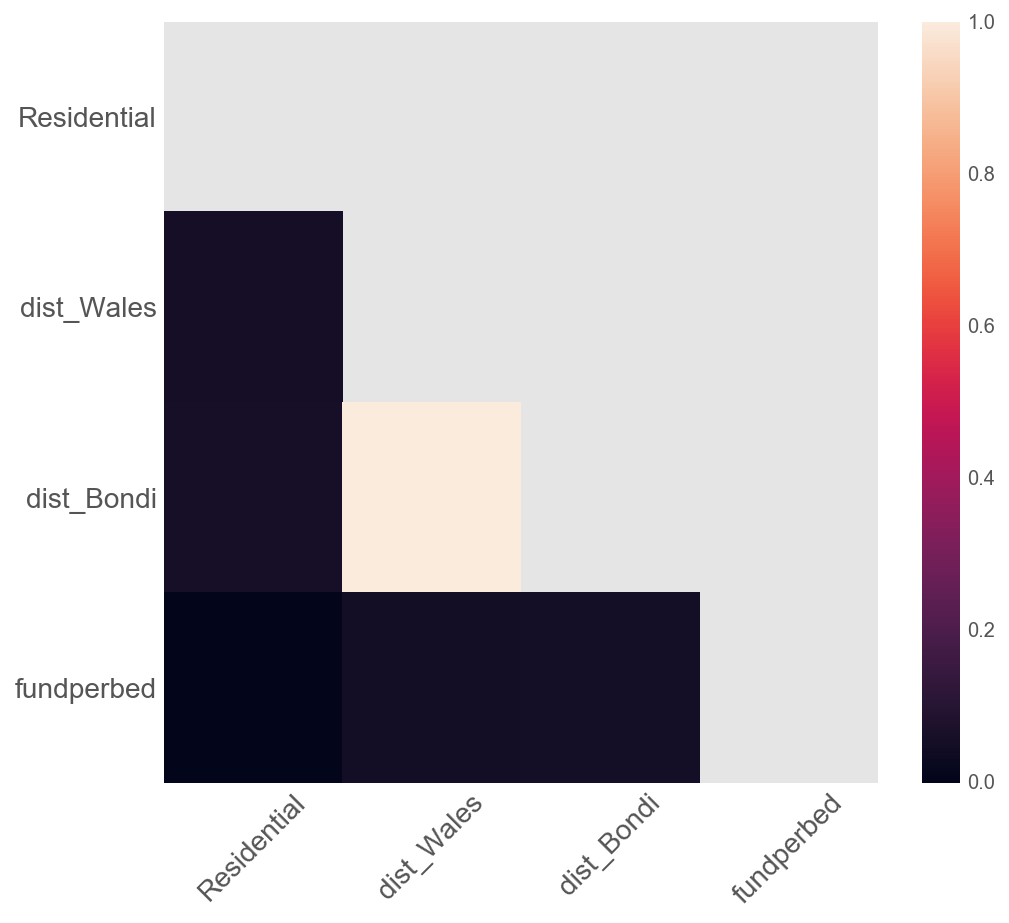

In [15]:
# create heatmap
hep_corr = distance.corr()

mask = np.zeros_like(hep_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(8,7))
ax = sns.heatmap(hep_corr, mask=mask)

ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=45)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=0)

plt.show()

# correlation is minimal

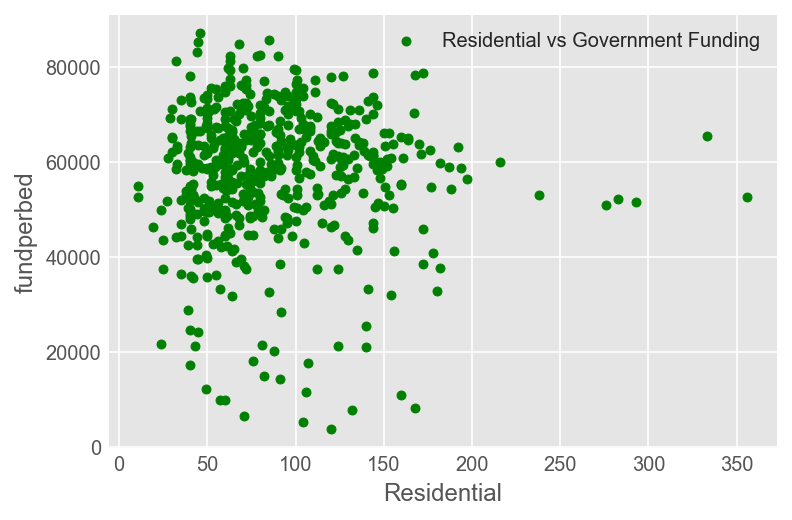

In [16]:
bx = distance.plot(kind='scatter', x='Residential',y='fundperbed',color = 'Green',label ='Residential vs Government Funding')

# data points are not that linear

## Decision Tree Regression

In [17]:
# apply the features to x and y
Xr=distance[['Residential','dist_Wales','dist_Bondi']]
yr=distance.fundperbed.values

In [18]:
# Initliaze import
from sklearn.linear_model import LinearRegression, LogisticRegression,LogisticRegressionCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

In [19]:
# Perform Linear Regression
reg_scores = cross_val_score(LinearRegression(), Xr, yr, cv=10)

print((reg_scores, np.mean(reg_scores)))

linreg = LinearRegression().fit(Xr, yr)

# score is -0.22. Indicates that the line is worse than the horizontal line

(array([-0.13147645, -0.24510623, -0.24510477,  0.01058841, -0.1737754 ,
       -0.16334503, -0.63054674, -0.20841061,  0.02362078, -0.47632312]), -0.22398791623512357)


In [20]:
# Decision Tree Regression
dtr1 = DecisionTreeRegressor(max_depth=1)
dtr2 = DecisionTreeRegressor(max_depth=2)
dtr3 = DecisionTreeRegressor(max_depth=3)
dtrN = DecisionTreeRegressor(max_depth=None)

In [21]:
dtr1.fit(Xr, yr)
dtr2.fit(Xr, yr)
dtr3.fit(Xr, yr)
dtrN.fit(Xr, yr)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [22]:
dtr1_scores = cross_val_score(dtr1, Xr, yr, cv=10)
dtr2_scores = cross_val_score(dtr2, Xr, yr, cv=10)
dtr3_scores = cross_val_score(dtr3, Xr, yr, cv=10)
dtrN_scores = cross_val_score(dtrN, Xr, yr, cv=10)

print((dtr1_scores, np.mean(dtr1_scores)))
print((dtr2_scores, np.mean(dtr2_scores)))
print((dtr3_scores, np.mean(dtr3_scores)))
print((dtrN_scores, np.mean(dtrN_scores)))

# cross validation scores are lower than the lr. This means the MSE (errors) are being reduced

(array([-0.18590792, -0.10503732, -0.18876405,  0.06469556, -0.23994262,
       -0.32018332, -0.75619776, -0.22607437,  0.10231716, -0.53876243]), -0.23938570688663913)
(array([-0.50667253, -0.10985958, -0.22324984,  0.13483626, -0.18562566,
       -0.35804976, -0.83116082, -0.36798234,  0.07531872, -0.50593662]), -0.28783821729210557)
(array([-0.4388348 , -0.17260492, -0.35971392, -0.07328339, -0.24959873,
       -0.5077897 , -1.25000655, -0.4282359 ,  0.03478343, -0.45854325]), -0.39038277344492794)
(array([-1.12645056, -0.83348525, -1.25722777, -1.25820065, -2.05986899,
       -0.96042613, -1.94888684, -1.40412195, -1.44416163, -0.45820938]), -1.275103915195663)


In [23]:
## Results from the linear regression and the decision tree regressor is not acceptable. r2 is a negative.
## Proceed to perform classifciation modesl

## Logistic Regression and K Nearest Neighbour (KNN)

* K-Nearest Neighbors takes a different approach to modeling than we have been practicing with linear models. In order to estimate a value (regression) or class membership (classification), the algorithm finds the observations in its training data that are "nearest" to the observation to predict. It then averages or takes a vote of those training observations' target values to estimate the value for the new data point.

* Distance is usually calculated using the euclidean distance. The "K" in KNN refers to the number of nearest neighbors that will be contributing to the prediction.

* Today we will be looking at KNN only in the context of classification

In [24]:
# initialize import
from sklearn.neighbors import KNeighborsClassifier

In [25]:
# drop columns from the dataframe
knn1=feature.drop(['dist_Clovelly','dist_BondiJunction','dist_Maroubra','dist_Coogee','dist_Vincent',
                       'dist_CBD','dist_Alfred','dist_StGeorge','PhysicalAddressSuburb','Year','AustralianGovernmentFunding',
                       'Longitude','Latitude'],axis=1)

In [26]:
knn1.head()

,Servicename,Residential,dist_Wales,dist_Bondi,fundperbed
0,St Basil's Annandale,83,7.744212,9.515312,62005.554217
1,Macquarie Lodge Aged Care Plus Centre,130,9.846089,13.956046,67601.038462
2,A H Orr Lodge,60,10.746170,13.701145,54300.083333
3,Opal Cardinal Freeman,135,10.535436,13.516029,41367.851852
4,Weeroona Aged Care Plus Centre,104,21.801215,24.999496,67859.471154


In [27]:
# Check for high and low fund level
distance.fundperbed.describe()

count      555.000000
mean     57872.382785
std      14028.521859
min       3823.000000
25%      51136.280898
50%      59924.500000
75%      67045.112857
max      86986.239130
Name: fundperbed, dtype: float64

In [28]:
# index the facility name
knn1.set_index('Servicename', inplace=True)

In [29]:
# Categorise the fund per bed into 3 (high) and 1 (low)
bed = []
for home in distance['fundperbed']:
    if home >= 55000:
        bed.append ('3') # high
    else:
        bed.append ('1') # low

knn1['fund_level'] = bed

In [30]:
# review the fund level
knn1.fund_level.value_counts()

3    354
1    201
Name: fund_level, dtype: int64

In [31]:
# create a new column to calculate the baseline
knn1['y_fund']=knn1.fund_level

In [32]:
# convert the column to numeric
knn1['y_fund'] = knn1['y_fund'].convert_objects(convert_numeric=True)

C:\Users\lynn_\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use Series.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  


In [33]:
# define the field
y_fund=knn1.y_fund

In [34]:
# calculate the baseline accuracy:
y_fund.value_counts()/y_fund.sum()

3    0.280285
1    0.159145
Name: y_fund, dtype: float64

In [35]:
# Convert the records to binary
dummies = pd.get_dummies(knn1[['fund_level']], drop_first = True)

In [36]:
# Merge the dataframe result back onto the original dataframe
knn1 = knn1.merge(dummies, left_index = True, right_index = True,how = 'outer')

In [37]:
knn1.head()

,Residential,dist_Wales,dist_Bondi,fundperbed,fund_level,y_fund,fund_level_3
Servicename,,,,,,,
A H Orr Lodge,60,10.746170,13.701145,54300.083333,1,1,0
ACDMA Aged Hostel,79,27.317185,30.360327,53443.506329,1,1,0
Abel Tasman Village,91,22.361381,25.302838,38549.043956,1,1,0
Adelene Court Hostel,35,57.586727,53.917995,36308.657143,1,1,0
Adelene Nursing Home,71,57.586727,53.917995,38178.380282,1,1,0


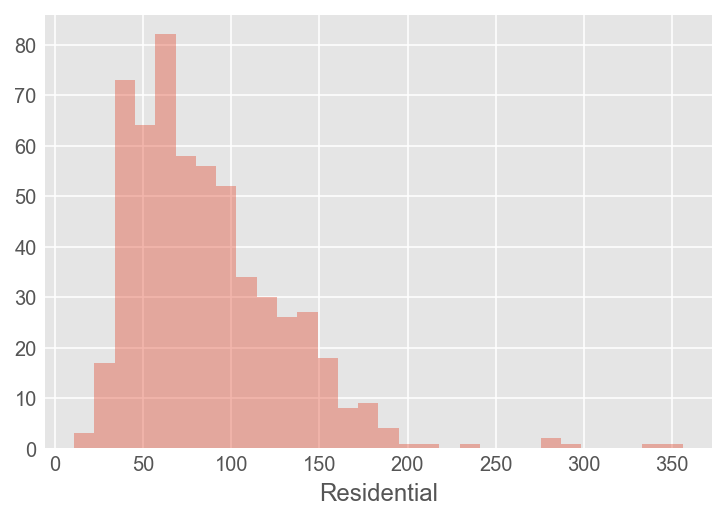

In [38]:
# review the Residential/ places numbers
sns.distplot(knn1.Residential, bins=30, kde=False)

In [39]:
# Set the x and y
X2 = knn1.drop(['fund_level','y_fund','fundperbed'], axis = 1)
y2 = knn1['fund_level'].values

In [40]:
# Check the data
X2.head()

,Residential,dist_Wales,dist_Bondi,fund_level_3
Servicename,,,,
A H Orr Lodge,60,10.746170,13.701145,0
ACDMA Aged Hostel,79,27.317185,30.360327,0
Abel Tasman Village,91,22.361381,25.302838,0
Adelene Court Hostel,35,57.586727,53.917995,0
Adelene Nursing Home,71,57.586727,53.917995,0


In [41]:
# review the columns
X2.columns

Index(['Residential', 'dist_Wales', 'dist_Bondi', 'fund_level_3'], dtype='object')

In [42]:
# Standardize the predictor matrix
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
Xs = ss.fit_transform(X2)

In [43]:
from sklearn.model_selection import cross_val_score

lr = LogisticRegression()

# using a 25-fold cross-val for fun
scores = cross_val_score(lr, Xs, y2, cv=25)
print(scores)
print(np.mean(scores))

# Logistic Regression result is too good

[1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         0.95454545 0.81818182 0.77272727 0.81818182
 1.        ]
0.9745454545454545


In [44]:
from sklearn.model_selection import train_test_split
# Create a 50-50 train-test split. Fit the model on training and get the predictions and predicted probabilities on the test data.
# Split data into training and testing with 25% in testing.
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.50, random_state=12)

# STEP 2: train the model on the training set
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)

# STEP 3: test the model on the testing set, and check the accuracy
y_pred_class = knn.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred_class))

# KNN result is acceptable

0.656140350877193


C:\Users\lynn_\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "C:\Users\lynn_\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\lynn_\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\lynn_\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\lynn_\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\lynn_\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 478, in start
    self.io_loop.start()
  File "C:\Users\lynn_\A

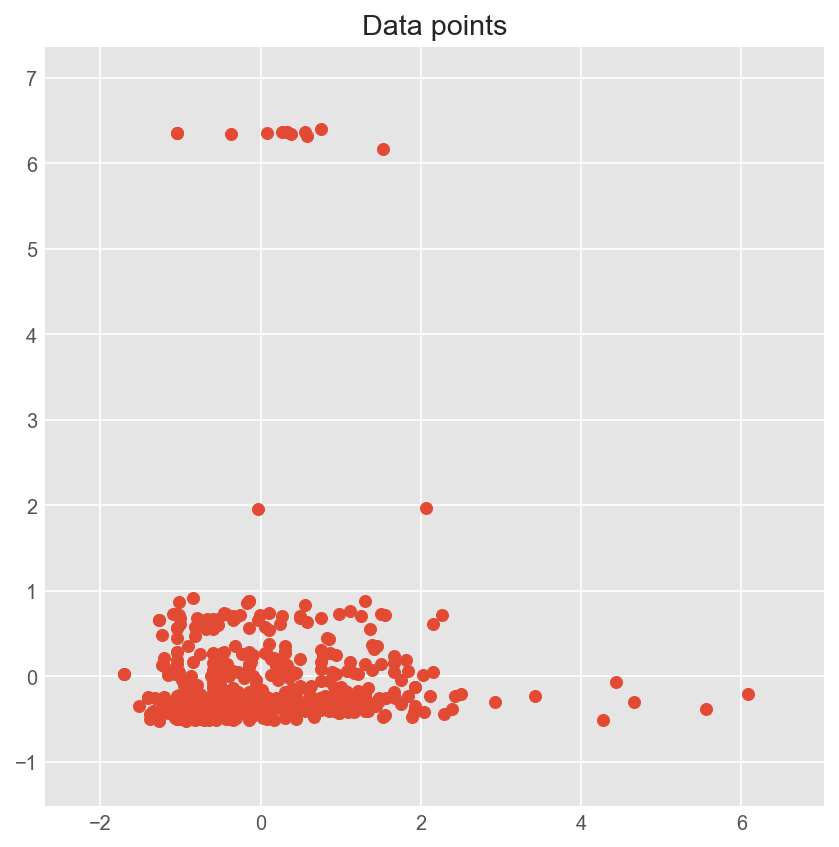

In [45]:
# Review the data points without KNN in a plot
import matplotlib
matplotlib.use('GTKAgg')
 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import neighbors

 
# take the first two features
X = Xs
Y = y2
h = .05  # step size in the mesh
 
# Calculate min, max and limits
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
 
# Put the result into a color plot
plt.figure(figsize=(7,7))

plt.scatter(X[:, 0], X[:, 1])
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("Data points")
plt.show()

In [46]:
# plot the KNN
folds = 5
max_neighbors = np.floor(Xs.shape[0] - Xs.shape[0]/5.)

print(max_neighbors)

# plot test accuracy by number of neighbors:
test_acc = []
for i in range(1, int(max_neighbors)):
    knn = KNeighborsClassifier(n_neighbors=i)
    test_acc.append(np.mean(cross_val_score(knn, Xs, y2, cv=5)))

455.0


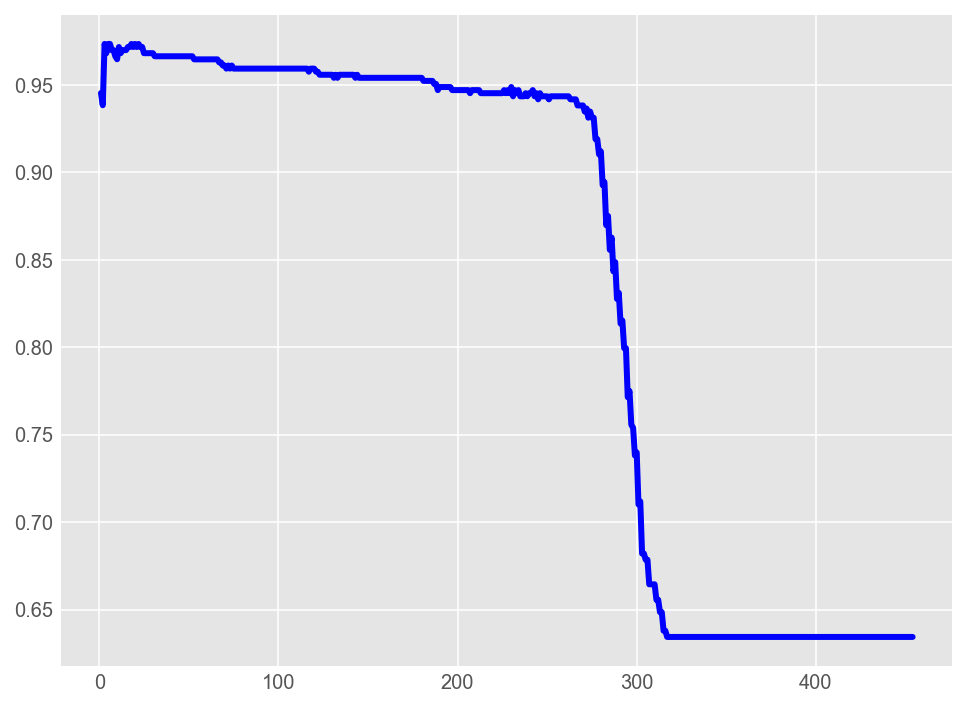

In [47]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(list(range(1, int(max_neighbors))), test_acc, lw=3., color='blue')
plt.show()
# accuracy at 95% above due to the max neighbours

## Perform GridSearch

In [48]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

lr = LogisticRegression()
lr.fit(X_train, y_train)

print(lr.score(X_test, y_test))

0.9754385964912281


In [49]:
from sklearn.model_selection import GridSearchCV
# Set up the parameters. Looking at C regularization strengths on a log scale.
# This takes awhile...
gs_params = {
    'penalty':['l1','l2'],
    'solver':['liblinear'],
    'C':np.logspace(-5,0,100)
}

lr_gridsearch = GridSearchCV(LogisticRegression(), gs_params, cv=5, verbose=1)


In [50]:
lr_gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    5.9s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'solver': ['liblinear'], 'C': array([1.00000e-05, 1.12332e-05, ..., 8.90215e-01, 1.00000e+00])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [51]:
# best score on the training data:
lr_gridsearch.best_score_

0.9753521126760564

In [52]:
# best parameters on the training data:
lr_gridsearch.best_params_

{'C': 0.03430469286314919, 'penalty': 'l1', 'solver': 'liblinear'}

In [53]:
# assign the best estimator to a variable:
best_lr = lr_gridsearch.best_estimator_

In [54]:
# Score it on the testing data:
best_lr.score(X_test, y_test)

0.9754385964912281

In [56]:
y_pred_lr=lr_gridsearch.predict(X_test)

In [60]:
from sklearn.metrics import accuracy_score
print(accuracy_score (y_test,y_pred_lr))

0.9754385964912281


## Get the coefficients

In [61]:
# Get the coefficients
coef_df = pd.DataFrame({
        'coef':best_lr.coef_[0],
        'feature':X2.columns
    })

In [62]:
coef_df['abs_coef'] = np.abs(coef_df.coef)

In [63]:
# sort by absolute value of coefficient (magnitude)
coef_df.sort_values('abs_coef', ascending=False, inplace=True)

In [64]:
# Show non-zero coefs and predictors
coef_df[coef_df.coef != 0]

,coef,feature,abs_coef
3,1.911982,fund_level_3,1.911982
0,-0.003566,Residential,0.003566
1,-0.000624,dist_Wales,0.000624


## Support Vector Machine

In [54]:
# initilize the imports
from sklearn import svm, linear_model

In [55]:
# Let's try a SVM
clf = svm.SVC()
print(cross_val_score(clf, X2, y2, cv=5, scoring='accuracy').mean())
# Close to KNN

# try a kernel
clf = svm.SVC(kernel='linear')
print(cross_val_score(clf, X2, y2, cv=5, scoring='accuracy').mean())

0.645028519741061
0.9752212389380531


#### The number of places influences the level of government as oppose to the location of the residential aged care facility

C:\Users\lynn_\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


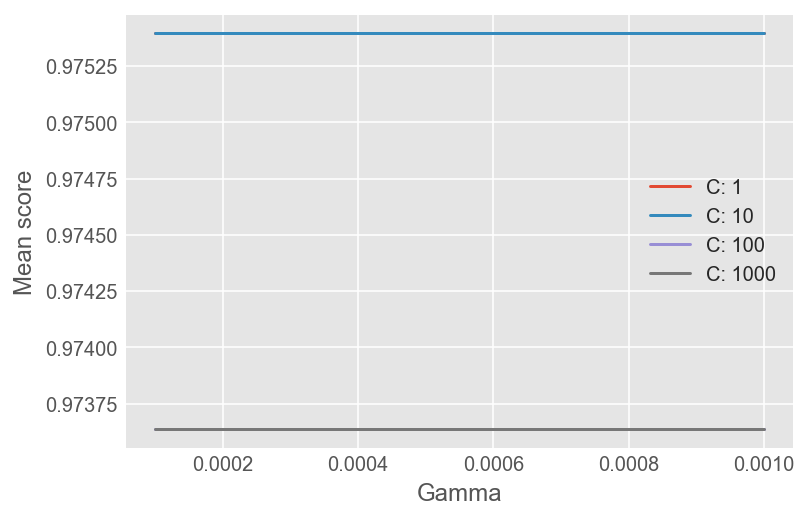

In [56]:
# Plot the gridsearch with the SVM
clf_ = svm.SVC(kernel='linear')
Cs = [1, 10, 100, 1000]
Gammas = [1e-3, 1e-4]
clf = GridSearchCV(clf_,
            dict(C=Cs,
                 gamma=Gammas),
                 cv=5,
                 pre_dispatch='1*n_jobs',
                 n_jobs=1)

clf.fit(X2, y2)

scores = [x[1] for x in clf.grid_scores_]
scores = np.array(scores).reshape(len(Cs), len(Gammas))

for ind, i in enumerate(Cs):
    plt.plot(Gammas, scores[ind], label='C: ' + str(i))
plt.legend()
plt.xlabel('Gamma')
plt.ylabel('Mean score')
plt.show()

In [ ]:
clf_ = svm.SVC(kernel='linear')
Cs = [1, 10, 100, 1000]
Gammas = [1e-3, 1e-4]
clf = GridSearchCV(clf_,
            dict(C=Cs,
                 gamma=Gammas),
                 cv=5,
                 pre_dispatch='1*n_jobs',
                 n_jobs=1)

clf.fit(X2, y2)

scores = [x[1] for x in clf.cv_results_]
scores = np.array(scores).reshape(len(Cs), len(Gammas))

for ind, i in enumerate(Cs):
    plt.plot(Gammas, scores[ind], label='C: ' + str(i))
plt.legend()
plt.xlabel('Gamma')
plt.ylabel('Mean score')
plt.show()